# Sao Paulo's Housing Prices

### 1. Residential Properties for Sale in the City of Sao Paulo

Sao Paulo is the 8th most populous city on Earth and its metropolitan region, with over 30 million inhabitants, one of the largest urban agglomerations in the world. Its real estate market is a critical part of the economy and it has a huge impact on many aspects of life. In this notebook, you will find a comprehensive analysis of the residential properties for sale accross different neighborhoods. The purpose is to look for insights in the data and identify the key aspects that define housing prices in the geographic context.

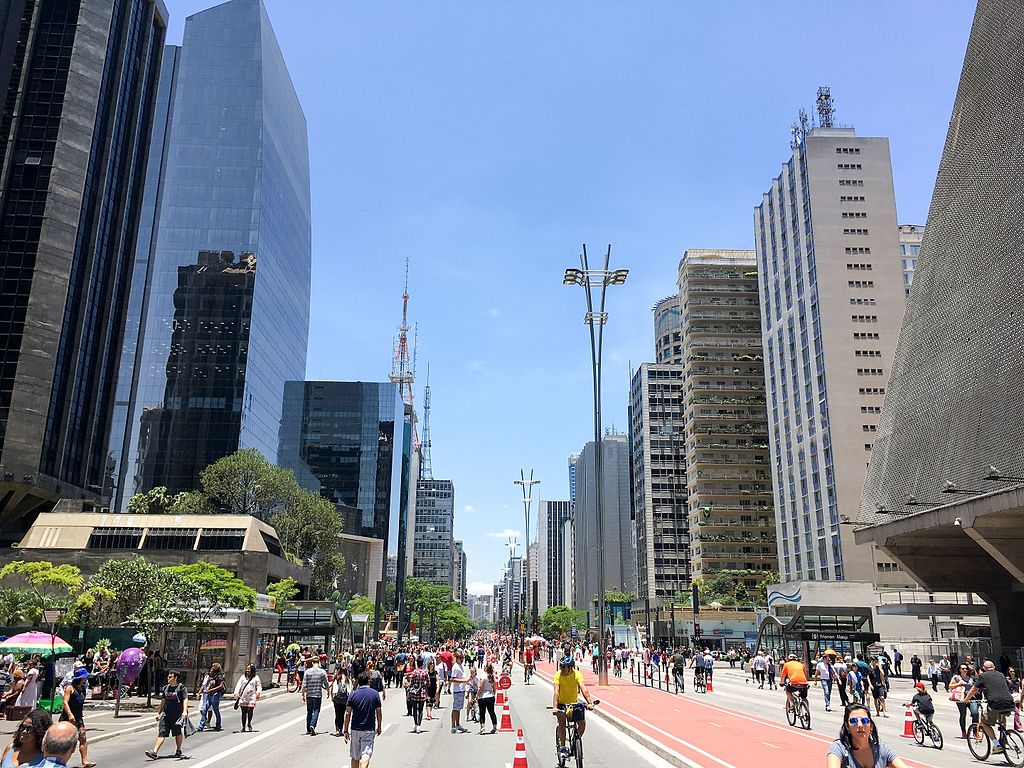

Let's take a look at the data, which consists of four files:
- **[Sao_Paulo.csv](https://www.kaggle.com/datasets/kaggleshashankk/house-price-data-of-sao-paulo):** contains a list of residential properties announced in the city.
- **sp_addresses.csv:** contains a complete list of streets, postcodes, latitudes and longitudes for all cities in Brazil.
- **Basico_SP.csv:** contains census demographic data of Sao Paulo gathered by the Brazilian Institute of Geography and Statistics (IBGE), in 2010.
- **SP_Setores_2020.shp**: contains geospatial polygons that identify the sectors investigated by the Brazilian Institute of Geography and Statistics (IBGE), in 2010.

In [2]:
pip --version

pip 22.0.2 from /media/marianne/DATA/code/sp_housing/venv/lib/python3.10/site-packages/pip (python 3.10)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import libraries and read in dataset
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

properties = pd.read_csv('datasets/Sao_Paulo.csv')
postcodes = pd.read_csv('datasets/sp_addresses.csv')
demographics = pd.read_csv('datasets/Basico_SP1.csv', encoding='ISO-8859-1', sep=';', thousands='.', decimal=',', usecols=[0, 14, 21, 22, 23, 25])
geoid = gpd.read_file('datasets/SP_Setores_2020/SP_Setores_2020.shp')

## 2. Preparing and cleaning data




In [2]:
# Drop duplicates from properties
properties.drop_duplicates()

# Print the total number of residential properties
print('\nTotal number of properties announced in Sao Paulo dataset = ', len(properties.index))

# Dataset info
print(properties.info())

# Have a look at a random sample of 10 rows
properties.sample(10)


Total number of properties announced in Sao Paulo dataset =  10008
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB
None


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
772,"Avenida George Saville Dodd, 279",Jardim Guedala,São Paulo,555,4,5,8,R$ 20.000\n /Mês
5123,Rua Doutor Octávio de Oliveira Santos,Brooklin Paulista,São Paulo,300,4,5,3,R$ 1.350.000
8481,NaN,Jardim Boa Vista (Zona Oeste),São Paulo,125,3,2,3,R$ 550.000
9494,NaN,Vila Mariana,São Paulo,300,3,4,2,R$ 15.000\n /Mês
7004,NaN,Parque Peruche,São Paulo,120,2,2,2,R$ 380.000
4269,Rua Petrópolis,Sumaré,São Paulo,455,4,5,4,R$ 2.970.000
9057,NaN,Indianópolis,São Paulo,190,3,5,1,R$ 1.230.000
599,Rua Doutor José Augusto de Queiroz,Cidade Jardim,São Paulo,315,4,4,3,R$ 2.850.000
6339,Rua Matias Roxo,Vila Leopoldina,São Paulo,100,2,2,3,R$ 650.000
8270,NaN,Jardim Guarau,São Paulo,85,2,1,1,R$ 385.000


### properties df
By looking at a random sample of the dataset rows (from the above task), we observe that some entries in the columns like 'Rua' (address) and 'Bairro' (ward) may have null or inconsistent values (address with/without number), and that may impact the geographic generalization of the results. Also, the column 'Valor' (price) has special characters ('$', '.' , '/'), that may hinder future mathematical calculations.
Hence, the first step is to drop the rows without an address, and edit data into a consistent format, removing house numbers for identity protection. Then, we should confirm if any of the ward missing values can be filled based on entries with the same address values. Finally, we should remove the special characters in the 'Value' column.

In [7]:
# Keep rows with non-null addresses
prop_with_address = properties[properties['Rua'].notna()]

# Edit addresses into a consistant format
prop_with_address['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()


prop_with_address.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6574 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     6562 non-null   object
 2   Cidade     6574 non-null   object
 3   Metragem   6574 non-null   int64 
 4   Quartos    6574 non-null   int64 
 5   Banheiros  6574 non-null   int64 
 6   Vagas      6574 non-null   int64 
 7   Valor      6574 non-null   object
dtypes: int64(4), object(4)
memory usage: 462.2+ KB


/tmp/ipykernel_11784/1977921048.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  prop_with_address['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()
/tmp/ipykernel_11784/1977921048.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_with_address['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()


In [11]:
# Lookup addresses with ward missing values
prop_ward_missing = prop_with_address[prop_with_address['Bairro'].isna()]

# List of addresses with ward missing values
addresses = prop_ward_missing['Rua'].tolist()

# Lookup if missing values appear somewhere in the dataset
same_address = prop_with_address[prop_with_address['Rua'].isin(addresses)]

# Dictionary of missing values
same_address = same_address[same_address['Bairro'].notna()]
same_address = same_address.sort_values(['Rua', 'Bairro'])
full_address = dict(zip(same_address.Rua, same_address.Bairro))
full_address['Rua Professor Lúcio Martins Rodrigues'] = 'Morumbi'   # As we could not find other properties at this address, we lookedup in google maps and added this entry manually
print(full_address)

# Fill in ward missing values based on dictionary references
prop_with_address['Bairro'] = prop_with_address['Bairro'].fillna(prop_with_address['Rua'].apply(lambda x: full_address.get(x)))

prop_with_address.info()

{'Avenida Comendador Adibo Ares': 'Morumbi', 'Rua Alvorada do Sul': 'Jardim Guedala', 'Rua Madalena de Morais': 'Jardim Leonor', 'Rua Pacobá': 'Jardim Panorama', 'Rua Professor Eduardo Monteiro': 'Jardim Leonor', 'Rua Santo Eufredo': 'Jardim Guedala', 'Rua Vergueiro': 'Vila Firmiano Pinto', 'Rua Professor Lúcio Martins Rodrigues': 'Morumbi'}
<class 'pandas.core.frame.DataFrame'>
Index: 6575 entries, 0 to Bairro
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Rua        6574 non-null   object 
 1   Bairro     6574 non-null   object 
 2   Cidade     6574 non-null   object 
 3   Metragem   6574 non-null   float64
 4   Quartos    6574 non-null   float64
 5   Banheiros  6574 non-null   float64
 6   Vagas      6574 non-null   float64
 7   Valor      6574 non-null   object 
dtypes: float64(4), object(4)
memory usage: 720.3+ KB


/tmp/ipykernel_11784/3432316183.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_with_address['Bairro'] = prop_with_address['Bairro'].fillna(prop_with_address['Rua'].apply(lambda x: full_address.get(x)))


In [12]:
# Split column 'Valor'
prop_with_address[['Moeda', 'Valor_Anuncio', 'Tipo_Anuncio']] = prop_with_address['Valor'].str.split(expand=True)

# Filter properties for sale - rentals contain values 'per month/per year' in the column 'Tipo_Anuncio', therefore we will only keep null entries.
sale_properties = prop_with_address[prop_with_address['Tipo_Anuncio'].isna()]

# Convert 'Prices' format from string to float
sale_properties["Valor_BRL"] = sale_properties["Valor_Anuncio"].str.replace(".","").astype(float)

# Config display to suppress decimal cases and scientific notation of floats
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Keep columns relevants to the project
sale_properties = sale_properties.drop(['Valor', 'Moeda', 'Valor_Anuncio', 'Tipo_Anuncio'], axis=1)

# Checking entries and dtypes
sale_properties.sample(10)

/tmp/ipykernel_11784/1995719334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_with_address[['Moeda', 'Valor_Anuncio', 'Tipo_Anuncio']] = prop_with_address['Valor'].str.split(expand=True)
/tmp/ipykernel_11784/1995719334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_with_address[['Moeda', 'Valor_Anuncio', 'Tipo_Anuncio']] = prop_with_address['Valor'].str.split(expand=True)
/tmp/ipykernel_11784/1995719334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_BRL
5199,Alameda dos Guaicanãs,Planalto Paulista,São Paulo,202.00,3.00,3.00,2.00,1390000.00
568,Rua Dona Inácia Uchôa,Vila Mariana,São Paulo,154.00,3.00,2.00,2.00,850000.00
7906,Rua Itassuce,Pacaembu,São Paulo,2505.00,3.00,7.00,12.00,12500000.00
4196,Rua Itaperuna,Pacaembu,São Paulo,1000.00,3.00,7.00,4.00,11990000.00
8120,Rua Limonita,Quarta Parada,São Paulo,235.00,4.00,3.00,2.00,1100000.00
7562,Rua Comendador Bichara Moherdauí,Jardim Leonor,São Paulo,803.00,5.00,7.00,8.00,4950000.00
4055,Alameda dos Indígenas,Planalto Paulista,São Paulo,319.00,3.00,4.00,2.00,1450000.00
9457,Rua Tibiriçá,Brooklin Paulista,São Paulo,260.00,3.00,4.00,3.00,1730000.00
1325,Avenida Piassanguaba,Planalto Paulista,São Paulo,463.00,4.00,6.00,6.00,3000000.00
885,Largo Mestre de Aviz,Jardim Luzitânia,São Paulo,365.00,3.00,4.00,2.00,6000000.00


### postcodes df


In [17]:
# Have a look at a random sample of 10 rows
print(postcodes.sample(10))

# Filter postcodes of Sao Paulo
postcodes_sp = postcodes.query("nome_localidade == 'São Paulo'")

# Drop duplicates
postcodes_sp.drop_duplicates()

# Format addresses to enable join
postcodes_sp['rua'] = postcodes_sp['tipo_logr'] + ' ' + postcodes_sp['logr_nome']
postcodes_sp['rua'] = postcodes_sp['rua'].str.title().str.strip()
postcodes_sp.head()


       Unnamed: 0 tipo_logr                           logr_nome  \
34159      584732       Rua                              Noêmia   
39034      589607     Largo                         do Redentor   
900        543913       Rua                       Alayr Rebello   
52208      602781       Rua                          Bela Vista   
56170      909741       Rua                        da Conquista   
36962      587535       Rua                             Piaçaba   
43061      593634       Rua               Tenente Mário Barbedo   
37173      587746       Rua                             Piqueri   
17390      567963       Rua  Doutor Vitor Eugênio do Sacramento   
49702      600275       Rua         Maestro Lauro Pinto Ribeiro   

                                   logr_compl numero  \
34159                              Rua Noêmia    NaN   
39034                       Largo do Redentor    NaN   
900                         Rua Alayr Rebello    NaN   
52208                          Rua Bel

,Unnamed: 0,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude,rua
0,543013,Rua,George Dantu,Rua George Dantu,NaN,Chácara Maria Trindade,São Paulo,SP,5275051.00,-23.42,-46.81,Rua George Dantu
1,543014,Rua,Maria Augusta Fiske,Rua Maria Augusta Fiske,NaN,Chácara Maria Trindade,São Paulo,SP,5275055.00,-23.42,-46.81,Rua Maria Augusta Fiske
2,543015,Rua,Doutor Nilo Cairo,Rua Doutor Nilo Cairo,NaN,Chácara Maria Trindade,São Paulo,SP,5275060.00,-23.41,-46.82,Rua Doutor Nilo Cairo
3,543016,Rua,Leonel Martiniano,Rua Leonel Martiniano,NaN,Chácara Maria Trindade,São Paulo,SP,5275065.00,-23.42,-46.82,Rua Leonel Martiniano
4,543017,Rua,André Polak,Rua André Polak,NaN,Chácara Maria Trindade,São Paulo,SP,5275070.00,-23.42,-46.81,Rua André Polak


In [18]:

# Keep columns relevant to the project
postcodes_sp = postcodes_sp.drop(['tipo_logr', 'logr_nome', 'logr_compl', 'numero'], axis=1)

# Rename columns to improve data legibility
postcodes_sp.columns = ['Bairro', 'CEP', 'Latitude', 'Longitude', 'Rua']
postcodes_sp.info()

ValueError: Length mismatch: Expected axis has 8 elements, new values have 5 elements

### demographics df

In [ ]:
# Import libraries and read in dataset
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

properties = pd.read_csv('datasets/Sao_Paulo.csv')
postcodes = pd.read_csv('datasets/sp_addresses.csv')
demographics = pd.read_csv('datasets/Basico_SP1.csv', encoding='ISO-8859-1', sep=';', thousands='.', decimal=',', usecols=[0, 14, 21, 22, 23, 25])
geoid = gpd.read_file('datasets/SP_Setores_2020/SP_Setores_2020.shp')

### geoid df

In [ ]:
# Have a look at a random sample of 10 rows
print(geoid.sample())

# Filter geospatial polygons that belong to the city of Sao Paulo
geoid_sp = geoid[geoid.NM_MUN == "São Paulo"]

# Filter columns relevant to the project
geoid_sp = geoid_sp.drop(['CD_SIT', 'NM_SIT', 'CD_UF', 'NM_UF', 'SIGLA_UF', 'CD_MUN', 'CD_DIST', 'CD_SUBDIST', 'NM_SUBDIST'], axis=1)

# Convert column 'CD_SECTOR' data format from str to int
geoid_sp = geoid_sp.astype({'CD_SETOR':'int'})

# Validation
geoid_sp.head(10)

## 3. Joining the DataFrames

In [ ]:
# Keep rows with non-null addresses
prop_with_address = properties[properties['Rua'].notna()]

# Edit addresses into a consistant format
prop_with_address.loc['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()

# Lookup addresses with ward missing values
prop_ward_missing = prop_with_address[prop_with_address['Bairro'].isna()]

# List of addresses with ward missing values
addresses = prop_ward_missing['Rua'].tolist()

# Lookup if missing values appear somewhere in the dataset
same_address = prop_with_address[prop_with_address['Rua'].isin(addresses)]

# Dictionary of missing values
same_address = same_address[same_address['Bairro'].notna()]
same_address = same_address.sort_values(['Rua', 'Bairro'])
full_address = dict(zip(same_address.Rua, same_address.Bairro))
full_address['Rua Professor Lúcio Martins Rodrigues'] = 'Morumbi'   # As we could not find other properties at this address, we lookedup in google maps and added this entry manually
print(full_address)

# Fill in ward missing values based on dictionary references
prop_with_address.loc['Bairro'] = prop_with_address['Bairro'].fillna(prop_with_address['Rua'].apply(lambda x: full_address.get(x)))

# Split column 'Valor'
prop_with_address[['Moeda', 'Valor_Anuncio', 'Tipo_Anuncio']] = prop_with_address['Valor'].str.split(expand=True)

# Filter properties for sale - rentals contain values 'per month/per year' in the column 'Tipo_Anuncio', therefore we will only keep null entries.
sale_properties = prop_with_address[prop_with_address['Tipo_Anuncio'].isna()]

# Convert 'Prices' format from string to float
sale_properties["Valor_BRL"] = sale_properties["Valor_Anuncio"].str.replace(".","").astype(float)

# Config display to suppress decimal cases and scientific notation of floats
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Keep columns relevants to the project
sale_properties = sale_properties.drop(['Valor', 'Moeda', 'Valor_Anuncio', 'Tipo_Anuncio'], axis=1)

# Checking entries and dtypes
sale_properties.sample(10)

In [ ]:
from shapely.geometry import Point
latitude = -23.56 	
longitude = -46.59
Point(longitude, latitude)

In [ ]:
from shapely.geometry import Polygon
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])



In [ ]:
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]).contains(Point(0.1,0.9))

In [ ]:
# Define point by geographic coordinates
property_codes['Point'] = ''
for i in property_codes.index:
    property_codes['Point'][i] = Point(property_codes['Longitude'][i], property_codes['Latitude'][i])

# Map 
property_codes['setor_censo'] = property_codes["Point"].map(lambda x: geoid.loc[geoid.contains(x), 'CD_SETOR'].values).str[0]
property_codes.sample(10)

In [ ]:
# Save df to csv
property_codes.to_csv('/media/marianne/OS/Users/maria/Code/sp_housing/datasets/property_codes.csv')

In [ ]:
# Read full csv file
merged_data = pd.read_csv('/media/marianne/OS/Users/maria/Code/sp_housing/datasets/property_codes.csv')
merged_data.info()

## 4. Exploring property types

In [ ]:
# Find Average Home Floor Size
merged_data.Metragem.mean()

In [ ]:
# Property Announcements per District
sns.set()
plt.figure(figsize=(16,9))
ax = sns.countplot(x="Bairro", data=merged_data, order=merged_data.Bairro.value_counts().iloc[:50].index, color='teal')
ax.tick_params(axis='x', rotation=90)
plt.show()

In [ ]:
#2. Área média dos imóveis por bairro (amostra sem tratamento)

amedia_bairro = merged_data.groupby("Bairro")["Metragem"].mean()
mbairro_sorted = amedia_bairro.sort_values(ascending=False)
plt.figure(figsize=(16,9))
mbairro_sorted.head(50).plot.bar(title="Área Média dos Imóveis por Bairro de São Paulo")

In [ ]:
# Outlier Search: huge properties
huge_properties = merged_data.sort_values("Metragem", ascending=False)
huge_properties.head(10)

In [ ]:
#4. Boxplot amostra sem tratamento
plt.boxplot(merged_data["Metragem"])
plt.show()

Conforme informações da [Prefeitura Municipal de São Paulo](https://gestaourbana.prefeitura.sp.gov.br/area-e-frente-maximas-de-lote/), a área máxima de lote no território da zona urbana do Município é de **20.000m²** e a frente máxima é de 150m, ambas podendo ser menores de acordo com a zona na qual o lote está inserido, sendo que essa área pode ser maior para alguns usos, por exemplo, clubes, cemitérios, parques dentre outros.
As áreas listadas nos imóveis nº 9845 e 6600 excedem esse valor, é pouco provável que estas se enquadrem no perfil da amostra.

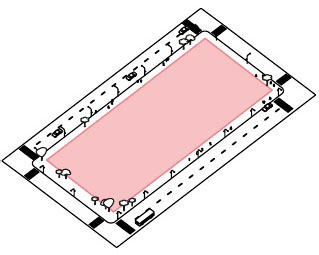

In [ ]:
#5. Contextualização dos imóveis mais amplos em seus respectivos bairros - Amostra 9845
index_bairro = merged_data.set_index("Bairro")
index_jd_guedala = index_bairro.loc["Jardim Guedala"]
index_jd_guedala.Metragem.sort_values(ascending=False)

In [ ]:
#6. Boxplot Jardim Guedala
plt.boxplot(index_jd_guedala["Metragem"])
plt.show()

In [ ]:
#7. Amostra 6600
index_s_represa = index_bairro.loc["Sítio Represa"]
index_s_represa

In [ ]:
#8. Soma de imóveis anunciados no Bairro Sítio Represa
sum((merged_data.Bairro == "Sítio Represa"))

A amostra 6600 possui área total de 37.000m² e constitui o único imóvel anunciado no Bairro Sítio Represa. Por exceder a área de lote urbano máxima prevista pela prefeitura, e por não apresentar dados comparativos da vizinhança, também será desconsiderada.

In [ ]:
#9. Amostra 7930
index_sto_amaro = index_bairro.loc["Santo Amaro"]
index_sto_amaro.Metragem.sort_values(ascending=False)

In [ ]:
#10. Boxplot Santo Amaro
plt.boxplot(index_sto_amaro["Metragem"])
plt.show()

As amostras 9845 e 7930 serão desconsideradas por não corresponderem a construções de mesma tipologia residencial das demais que compõem o banco de dados, além de destoarem completamente de outros imóveis no mesmo bairro.

In [ ]:
#11. Amostra 4788
index_v_castelo = index_bairro.loc["Vila Castelo"]
index_v_castelo

In [ ]:
#12. Soma de imóveis anunciados no Bairro Vila Castelo 
sum((merged_data["Bairro"] == "Vila Castelo"))

In [ ]:
#13. Amostras 7906, 7791, 7067
index_pacaembu = index_bairro.loc["Pacaembu"]
index_pacaembu.Metragem.sort_values(ascending=False)

In [ ]:
#14. Boxplot Pacaembu
plt.boxplot(index_pacaembu["Metragem"])
plt.show()

In [ ]:
#17. Amostra 1936
index_tucuruvi = index_bairro.loc["Tucuruvi"]
index_tucuruvi.Metragem.sort_values(ascending=False)

In [ ]:
#18. Boxplot Tucuruvi
plt.boxplot(index_tucuruvi["Metragem"])
plt.show()

As amostras 4788, 7906, 7791, 7067, 6908, 7026, e 1936 dos Bairros Vila Castelo, Pacaembu, Retiro Morumbi e Tucuruvi possuem área superior a 2.000m². Este valor destoa um pouco dos imóveis no contexto da vizinhança, porém é possível encontrar imóveis de metragem semelhante em outros bairros da cidade. Assim, por ora, essas amostras serão mantidas.

In [ ]:
#19. Busca de outliers: imóveis minusculos 
tiny_properties = merged_data.sort_values("Metragem")
tiny_properties.head(10)

In [ ]:
#20. Amostra 9603
index_v_guaca = index_bairro.loc["Vila Guaca"]
index_v_guaca

In [ ]:
#21. Soma de imóveis anunciados no Bairro Vila Guaca
sum((dados_bairro["Bairro"] == "Vila Guaca"))

A amostra 9603 é incrivelmente pequena, com 3 dormitórios acomodados em apenas 10m² é um imóvel impossível, por isso será desconsiderada.

In [ ]:
#22. Amostras 5009, 5059, 5652
index_jd_ampliacao = index_bairro.loc["Jardim Ampliação"]
index_jd_ampliacao.Metragem.sort_values(ascending=False)

In [ ]:
#23. Boxplot Jardim Ampliação
plt.boxplot(index_jd_ampliacao["Metragem"])
plt.show()

As amostras 5009, 5059 e 5652 também são pouco prováveis, com 3 dormitórios em 20-25m², mas viáveis, em alguma tipologia residencial com cozinha compartilhada ou algo do gênero, mas não há dados suficientes para confirmação, por isso seus dados serão mantidos.

In [ ]:
#24. Filtragem de outliers defeituosos
dados_area = dados_bairro.drop([9845, 6600, 7930, 4788, 9603])
dados_area.Metragem.describe()

In [ ]:
#25. Boxplot da amostra tratada
plt.boxplot(dados_area["Metragem"])
plt.show()

In [ ]:
#26. Área média dos imóveis por bairro (amostra tratada)
area_m_bairro = dados_area.groupby("Bairro")["Metragem"].mean()
area_m_bairro_sorted = area_m_bairro.sort_values(ascending=False)
plt.figure(figsize=(16,9))
area_m_bairro_sorted.head(50).plot.bar(title="Área Média dos Imóveis por Bairro de São Paulo")

## 5. Filter out "junk" properties

In [ ]:
dados_area.describe()

In [ ]:
tipos_imoveis = dados_area.groupby(['Quartos','Banheiros', 'Vagas']).agg({'Metragem':'mean'})
tipos_imoveis

In [ ]:
plt.figure(figsize=(16,9))
tipos_imoveis.head(20).plot.bar(title="Área Média dos Imóveis por Tipo")
plt.show()

In [ ]:
dados_area["Quartos"].value_counts()

In [ ]:
plt.boxplot(dados_area["Quartos"])
plt.show()

In [ ]:
dados_area["Banheiros"].value_counts()

In [ ]:
plt.boxplot(dados_area["Banheiros"])
plt.show()

In [ ]:
dados_area["Vagas"].value_counts()

In [ ]:
plt.boxplot(dados_area["Vagas"])
plt.show()

In [ ]:
dados_quartos = dados_area.query("Quartos <= 6")
dados_quartos

In [ ]:
dados_banheiros = dados_quartos.query("Banheiros <= 9")
dados_banheiros

In [ ]:
dados_vagas = dados_banheiros.query("Vagas <= 10")
dados_vagas

In [ ]:
dados_tipo = dados_vagas.set_index(["Quartos", "Banheiros", "Vagas"])
dados_tipo.sort_index()

In [ ]:
dados_tipo.info()

## 6. Geographic distribution

In [ ]:
#1. Número de amostras contidas no Bairro Vila Mariana
sum((dados["Bairro"] == "Vila Mariana"))

In [ ]:
#2. Máscara de filtragem de dados do Bairro Vila Mariana
bairro_vmariana = (dados.Bairro == "Vila Mariana")
bairro_vmariana

In [ ]:
#3. Subset da amostra contendo apenas imóveis do Bairro Vila Mariana
imoveis_vmariana = dados[bairro_vmariana]
imoveis_vmariana

In [ ]:
#4. Área média dos imóveis do Bairo Vila Mariana
imoveis_vmariana["Metragem"].mean()

## 7. Price per property type

In [ ]:
amedia_dorm = dados.groupby("Quartos")["Metragem"].agg([min, max, sum])
amedia_dorm

In [ ]:
dados.describe()

In [ ]:
dados.sort_values(["Metragem", "Quartos"], ascending=[False, True])

In [ ]:
dados.sort_values("Valor", ascending=False)

In [ ]:
dados["Bairro"]

In [ ]:
amedia_dorm = dados.groupby("Quartos")["Metragem"].mean()
amedia_dorm

In [ ]:
amedia_dorm.head(4).plot.bar()

In [ ]:
dados.plot.scatter(x="Quartos", y="Metragem", alpha=0.4)

In [ ]:
a_min_max_soma_bairro["min"].sort_values(ascending=False)

In [ ]:
a_min_max_soma_bairro["max"].sort_values(ascending=False)

In [ ]:
a_min_max_soma_bairro["sum"].sort_values(ascending=False)

In [ ]:
dados.groupby("Bairro")["Metragem", "Quartos"].mean()

In [ ]:

sum((dados["Bairro"]=="Vila Mariana")*1)

In [ ]:
dados.pivot_table(values="Metragem", index="Quartos")

In [ ]:
dados.pivot_table(values="Metragem", index="Bairro", columns="Quartos", fill_value=0)

In [ ]:
tipo_imovel = dados.set_index(["Quartos", "Banheiros"])
tipo_imovel

In [ ]:
tipo_imovel.loc[3]

In [ ]:
tipo_imovel.sort_values(["Bairro"], ascending=False)

In [ ]:
#Desafio 5: Identificar quais bairros estão sem nome de rua
dados.isna().sum()

In [ ]:
ruas_faltantes = dados.Rua == "None"
ruas_faltantes

In [ ]:
dados[dados_zero]


In [ ]:
#9. Importação do matplotlib
from matplotlib import pyplot as plt

In [ ]:
#10. Valores dos imóveis
plt.figure(figsize=(16,9))
plt.hist(dados_vendas["Valor_float"], range=(10000, 10000000))
plt.title("Valores de imóveis à venda anunciados em São Paulo")
plt.xlabel("Valores em Milhões de R$")
plt.ylabel("Quantidade de anúncios")
plt.style.use('seaborn')
plt.show()

## 8. Price per location

In [ ]:
#Desafio 3: Preço do metro quadrado por bairro
import numpy as np
dados_vendas["Valor_mqd"] = dados_vendas["Valor_float"] / dados_vendas["Metragem"]
dados_vendas["Valor_mqd"].sort_values(ascending=False)

In [ ]:
#Desafio 3: Preço do metro quadrado por bairro
mqd_bairro = dados_vendas.groupby("Bairro")["Valor_mqd"].mean()
mqd_bairro_sorted = mqd_bairro.sort_values(ascending=False)
plt.figure(figsize=(16,9))
mqd_bairro_sorted.head(50).plot.bar(title="Os 50 bairros mais caros para morar em São Paulo", xlabel="", ylabel="Valor do m² dos imóveis à venda")

In [ ]:
imoveis_dorm = dados["Quartos"].value_counts()
dorm_sorted = imoveis_dorm.sort_index()
dorm_sorted.head(8).plot.bar(title="Imóveis por número de dormitórios")

In [ ]:
#Desafio 4: Conclusão - os bairros listados constituem o percentil 75% da amostra. O valor mediano do metro quadrado residencial na capital paulistana é de 6500 reais, sendo possível encontrar uma ampla gama de imóveis por um preço moderado, entre 4000-5000 reais por metro quadrado.
dados_vendas.describe()

In [ ]:
#Desafio 5: Visualização para análise de quartis, mediana e outliers
plt.boxplot(dados_vendas["Valor_mqd"])
plt.show()

## 9. Price per location and monthly income
Desafios desta aula

- Tentar vincular dados do IBGE com os dados de imóveis.

- Tratar os outliers e comparar com os resultados.

- Agrupar por mais de uma categoria e realizar as análises.

- Organize o colab para deixar com cara de projeto.

In [ ]:
#1. Número de imóveis por bairro
imoveis_bairro = dados["Bairro"].value_counts()
imoveis_bairro

In [ ]:
#2. Gráfico de barras com número de imóveis por bairro
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))
imoveis_bairro.head(50).plot.bar(title= "Imóveis Anunciados à Venda por Bairro em São Paulo")

In [ ]:
dados_vendas["Rua"].str.extract(r'(^[\w ]+)')

In [ ]:
#1. Junção da malha censitária com os dados do censo
geo_stats = geo_sp.merge(dados_ibge, on = 'CD_SETOR')
geo_stats

In [ ]:
#2. Filtragem de dados redundantes
geo_stats = geo_stats.drop(['DISTRITO'], axis=1)
geo_stats

In [ ]:
#3. Importação do módulo de coordenadas espaciais
from shapely.geometry import Point
latitude = -23.56 	
longitude = -46.59
Point(longitude, latitude)

In [ ]:
#4. Importação do módulo de poligonais 
from shapely.geometry import Polygon
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])

In [ ]:
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]).contains(Point(0.1,0.9))

In [ ]:
cep_sp["Point"] = ""
for i in cep_sp.index:
    cep_sp["Point"][i] = Point(cep_sp["longitude"][i], cep_sp["latitude"][i])

cep_sp['setor_censo'] = cep_sp["Point"][:10].map(lambda x: geo_stats.loc[geo_stats.contains(x), 'CD_SETOR'].values).str[0]
cep_sp

In [ ]:
cep_sp.info()

In [ ]:
cep_sp["Point"] = ""
for i in cep.index:
    cep["Point"][i] = Point(cep["longitude"][i], cep["latitude"][i])

cep_sp['dados_geo'] = dados_geo["Point"][:10].map(lambda x: setor_censo_sp.loc[setor_censo_sp.contains(x), 'CD_GEOCODI'].values).str[0]
dados_geo

## 10. Price predicting model
Desafios desta aula

- Adicionar o valor "real" do m² do imóvel.

- Testar outro modelo de regressão.

- Criar um modelo baseline com as features originais.

- Trabalhar mais nos dados e criar novas variáveis.

- Testar as predições para casos reais.

- Criar um projeto com os resultados da Imersão e postar nas redes sociais mostrando o trabalho realizado.

In [ ]:
# Keep rows with non-null addresses
prop_with_address = properties[properties['Rua'].notna()]

# Edit addresses into a consistant format
prop_with_address.loc['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()

prop_with_address.info

In [5]:
# Keep rows with non-null addresses
prop_with_address = properties[properties['Rua'].notna()]

# Edit addresses into a consistant format
prop_with_address.loc['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()

prop_with_address.info

/tmp/ipykernel_24760/2346949295.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  prop_with_address.loc['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()
/tmp/ipykernel_24760/2346949295.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_with_address.loc['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()
